In [18]:
import numpy as np
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
from utilities_new_new import *
import matplotlib.pyplot as plt


In [19]:
def plot_roc_2(classifier, X_train, y_test, label, plot):
    fpr, tpr, roc_auc = compute_roc(classifier, X_train, y_test)
    plot.plot(fpr, tpr, lw=2, label=label+f" (AUC = {roc_auc:.4f})")
    return plot

In [20]:
def plot_precision_recall_2(classifier, X_train, y_test, name, titlestring):
    plt.figure(figsize=(8, 8))
    precision_arr, recall_arr, pr_auc, chance_level = compute_precision_recall(classifier, X_train, y_test)
    plt.plot(recall_arr, precision_arr, lw=2, label=f"{name} (AUC = {pr_auc:.4f})")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1])
    plt.ylim([0.5, 1.0])
    plt.title(titlestring+'Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

In [21]:
def prepare_data_eFEX_GEP(data_subdir,accept_data_filename,reject_data_filename,distance_boundaries):
    save_path = os.path.join(os.path.pardir, "data", data_subdir)
    if os.path.exists(os.path.join(save_path, "np_data.npz")):
        print(f"found preprepared data in {save_path}")
        np_data = np.load(os.path.join(save_path, "np_data.npz"))
        input_np1, input_np2, labels_np = np_data["input_np1"], np_data["input_np2"], np_data["labels_np"]

    else:
        print(f"preprepared data in {save_path} is missing, preparing and saving here")
        accept_data_path = os.path.join(parent_dir, "data", accept_data_filename)
        reject_data_path = os.path.join(parent_dir, "data", reject_data_filename)
        DFs = import_data_files([accept_data_path, reject_data_path])
        accepted_numpy_eFEX = ak.to_numpy(DFs[0]['SuperCell_ET'])
        rejected_numpy_eFEX = ak.to_numpy(DFs[1]['SuperCell_ET'])
        print("attempting to generate topo training data")
        accepted_numpy_GEP = generate_topocluster_ET_distribution(DFs[0], distance_boundaries)
        rejected_numpy_GEP = generate_topocluster_ET_distribution(DFs[1], distance_boundaries)
        accepted_labels = np.ones(DFs[0].shape[0])
        rejected_labels = np.zeros(DFs[1].shape[0])    
        input_np1 = np.concatenate((accepted_numpy_eFEX, rejected_numpy_eFEX), axis=0)
        input_np2 = np.concatenate((accepted_numpy_GEP, rejected_numpy_GEP), axis=0)
        labels_np = np.concatenate((accepted_labels, rejected_labels), axis=0)
        
        if not os.path.exists(save_path):
                os.mkdir(save_path)
        np.savez(os.path.join(save_path,"np_data.npz"), input_np1=input_np1, input_np2=input_np2, labels_np=labels_np)

    return input_np1, input_np2, labels_np


In [28]:
def eFEX_GEP_loop(classifiers_1,classifiers_2,accept_data_filename,reject_data_filename,distance_boundaries,data_subdir,TSNE_only=False):
    rejection_rates_heuristic =  [0.0, 0.8009311588352441, 0.8357150546315733, 0.8618870768071478]
    id_efficiencies_heuristic = [1.0, 0.9905439553132065, 0.9805160260672962, 0.9638515760074478]

    classifiers = import_all_classifiers()
    input_np1, input_np2, labels_np = prepare_data_eFEX_GEP(data_subdir,accept_data_filename,reject_data_filename,distance_boundaries)
    X_train, X_test, X_train_topo, X_test_topo, y_train, y_test = train_test_split(input_np1, input_np2, labels_np, test_size=0.2, random_state=42)

    for name_1 in classifiers_1:
        Classifier1 = classifiers[name_1]
        if name_1 == "VotingClassifier":
            clf = Classifier1(estimators=[("lr", LogisticRegression()), ("rf", RandomForestClassifier())], voting='soft')
        else:
            clf = Classifier1()
        clf.fit(X_train, y_train)

        if hasattr(clf, "decision_function"):  # For models like SVM or SGD
            y_scores = clf.decision_function(X_test)
        elif hasattr(clf, "predict_proba"):  # For models like XGBoost or other tree-based models
            probs = clf.predict_proba(X_test)
            y_scores = probs[:, 1] if probs.shape[1] > 1 else probs[:, 0]

        X_test_extended = np.hstack((X_test_topo, y_scores.reshape(-1, 1))) #not sure about reshaping
        X_train2, X_test2, X_train3, X_test3, y_train2, y_test2 = train_test_split(X_test_extended, X_test, y_test, test_size=0.2, random_state=42)
        if TSNE_only:
            X_test_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_test2) 
            plot_2D_TSNE(X_test_embedded,y_test2,f"t-SNE visualization of true for ({name_1}) eFEX + GEP training data")
        else:
            print("before second training with topo: (eFEX)")
            y_pred1 = clf.predict(X_test3)
            tn, fp, fn, tp, accuracy, recall, precision, f1, mse = evaluate_sklearn_model(y_test2, y_pred1, classifier_name=f'{name_1}')
            # fig, ax= plt.subplots()
            import matplotlib.pyplot as plt
            plt.figure(figsize=(8, 8))
            plt = plot_roc_2(clf, X_test3, y_test2, name_1+" (eFEX)",plt)
            # plot_precision_recall_2(clf, X_test3, y_test2, name_1, "eFEX decision")

            for name_2 in classifiers_2:
                Classifier2 = classifiers[name_2]
                if name_2 == "VotingClassifier":
                    clf2 = Classifier2(estimators=[("lr", LogisticRegression()), ("rf", RandomForestClassifier())], voting='soft')
                else:
                    clf2 = Classifier2()

                clf2.fit(X_train2, y_train2)

                print("after second training with topo: (eFEX + GEP)")
                y_pred2 = clf2.predict(X_test2)
                tn, fp, fn, tp, accuracy, recall, precision, f1, mse = evaluate_sklearn_model(y_test2, y_pred2, classifier_name=f'{name_2}')
                plt = plot_roc_2(clf2, X_test2, y_test2, f"{name_1} (eFEX) + {name_2} (GEP)", plt)
                # plot_precision_recall_2(clf2, X_test2, y_test2, name_2, "eFEX decision + topocluster ([0.0125,0.025,0.05,0.1,0.2,0.4] ring))")

        if not TSNE_only:
            for i in range(1,4):
                # plt.scatter(1.-rejection_rates_heuristic[i],id_efficiencies_heuristic[i], color='r', marker='s', label='Heuristic' if i == 1 else '')
                plt.scatter(1.-rejection_rates_heuristic[i],id_efficiencies_heuristic[i], color='r', marker='s')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 0.2])
            plt.ylim([0.92, 1.0])
            plt.xlabel('False Positive Rate (Electron Efficiency)')
            plt.ylabel('True Positive Rate (Jet Survivial Probability)')
            plt.title('eFEX + GEP ROC Curve Comparison')
            plt.legend(loc='lower left')
            plt.show()

Imported 43 binary classifiers:
['AdaBoostClassifier', 'BaggingClassifier', 'BernoulliNB', 'CalibratedClassifierCV', 'CategoricalNB', 'ClassifierChain', 'ComplementNB', 'DecisionTreeClassifier', 'DummyClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'FixedThresholdClassifier', 'GaussianNB', 'GaussianProcessClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'KNeighborsClassifier', 'LabelPropagation', 'LabelSpreading', 'LinearDiscriminantAnalysis', 'LinearSVC', 'LogisticRegression', 'LogisticRegressionCV', 'MLPClassifier', 'MultiOutputClassifier', 'MultinomialNB', 'NearestCentroid', 'NuSVC', 'OneVsOneClassifier', 'OneVsRestClassifier', 'OutputCodeClassifier', 'PassiveAggressiveClassifier', 'Perceptron', 'QuadraticDiscriminantAnalysis', 'RadiusNeighborsClassifier', 'RandomForestClassifier', 'RidgeClassifier', 'RidgeClassifierCV', 'SGDClassifier', 'SVC', 'TunedThresholdClassifierCV', 'VotingClassifier', 'XGBClassifier']
found preprepared data in ..\data

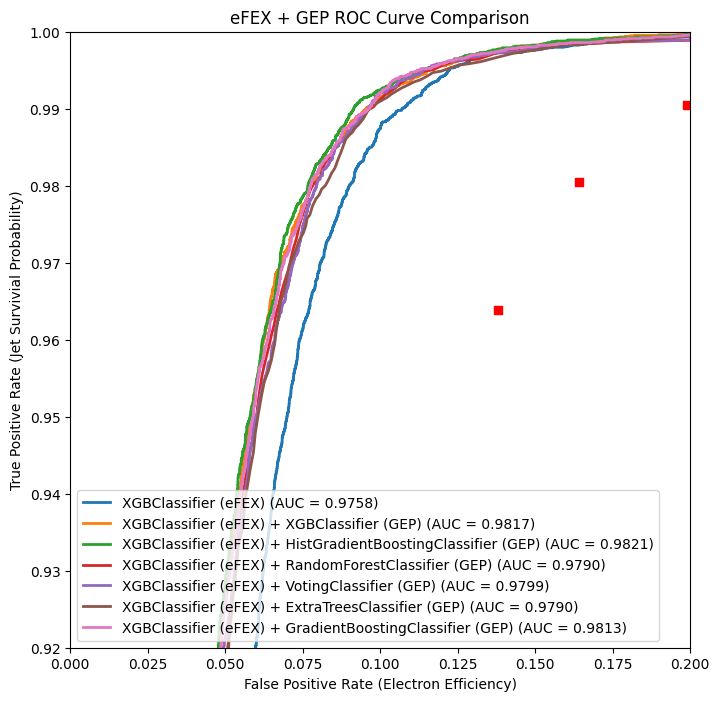

before second training with topo: (eFEX)


Evaluation of MLPClassifier
Confusion Matrix:
 [[19886  1536]
 [  429 14441]]
Accuracy: 0.94585584
Recall: 0.97114997
Precision: 0.90386180
F1 Score: 0.93629851
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95     21422
         1.0       0.90      0.97      0.94     14870

    accuracy                           0.95     36292
   macro avg       0.94      0.95      0.94     36292
weighted avg       0.95      0.95      0.95     36292

Mean Squared Error: 0.05414416

after second training with topo: (eFEX + GEP)


Evaluation of XGBClassifier
Confusion Matrix:
 [[20074  1348]
 [  472 14398]]
Accuracy: 0.94985121
Recall: 0.96825824
Precision: 0.91439096
F1 Score: 0.94055396
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     21422
         1.0       0.91      0.97      0.94     14870

    accuracy    

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


after second training with topo: (eFEX + GEP)


Evaluation of VotingClassifier
Confusion Matrix:
 [[20072  1350]
 [  448 14422]]
Accuracy: 0.95045740
Recall: 0.96987223
Precision: 0.91440528
F1 Score: 0.94132237
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     21422
         1.0       0.91      0.97      0.94     14870

    accuracy                           0.95     36292
   macro avg       0.95      0.95      0.95     36292
weighted avg       0.95      0.95      0.95     36292

Mean Squared Error: 0.04954260

after second training with topo: (eFEX + GEP)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[20071  1351]
 [  496 14374]]
Accuracy: 0.94910724
Recall: 0.96664425
Precision: 0.91408585
F1 Score: 0.93963066
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     21422
         1.0       0.91      0.97      0.94     14870

 

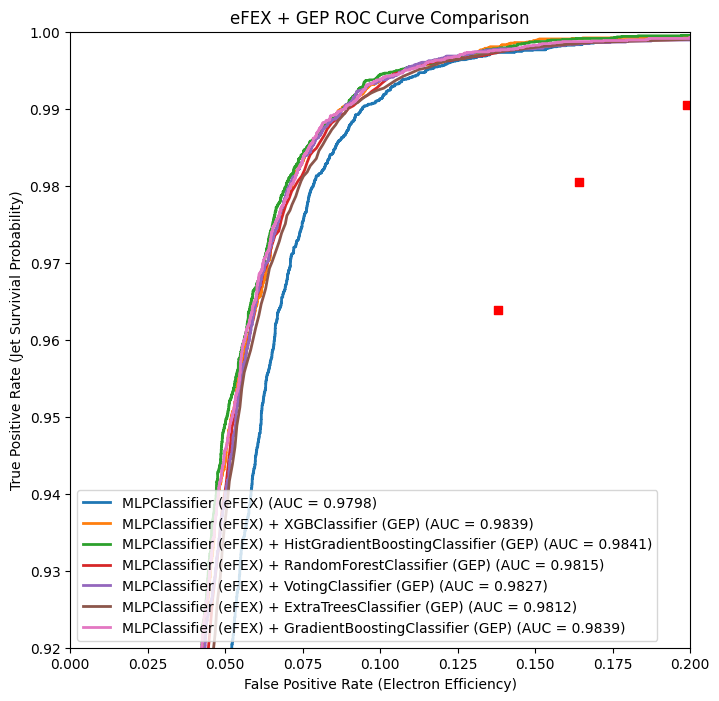

before second training with topo: (eFEX)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[19728  1694]
 [  413 14457]]
Accuracy: 0.94194313
Recall: 0.97222596
Precision: 0.89511485
F1 Score: 0.93207827
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     21422
         1.0       0.90      0.97      0.93     14870

    accuracy                           0.94     36292
   macro avg       0.94      0.95      0.94     36292
weighted avg       0.94      0.94      0.94     36292

Mean Squared Error: 0.05805687

after second training with topo: (eFEX + GEP)


Evaluation of XGBClassifier
Confusion Matrix:
 [[20041  1381]
 [  511 14359]]
Accuracy: 0.94786730
Recall: 0.96563551
Precision: 0.91226175
F1 Score: 0.93819013
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.94      0.95     21422
         1.0       0.91      0.97      0.94     14870

    accur

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


after second training with topo: (eFEX + GEP)


Evaluation of VotingClassifier
Confusion Matrix:
 [[20054  1368]
 [  519 14351]]
Accuracy: 0.94800507
Recall: 0.96509751
Precision: 0.91297156
F1 Score: 0.93831116
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.96     21422
         1.0       0.91      0.97      0.94     14870

    accuracy                           0.95     36292
   macro avg       0.94      0.95      0.95     36292
weighted avg       0.95      0.95      0.95     36292

Mean Squared Error: 0.05199493

after second training with topo: (eFEX + GEP)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[20004  1418]
 [  536 14334]]
Accuracy: 0.94615893
Recall: 0.96395427
Precision: 0.90997969
F1 Score: 0.93618967
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     21422
         1.0       0.91      0.96      0.94     14870

 

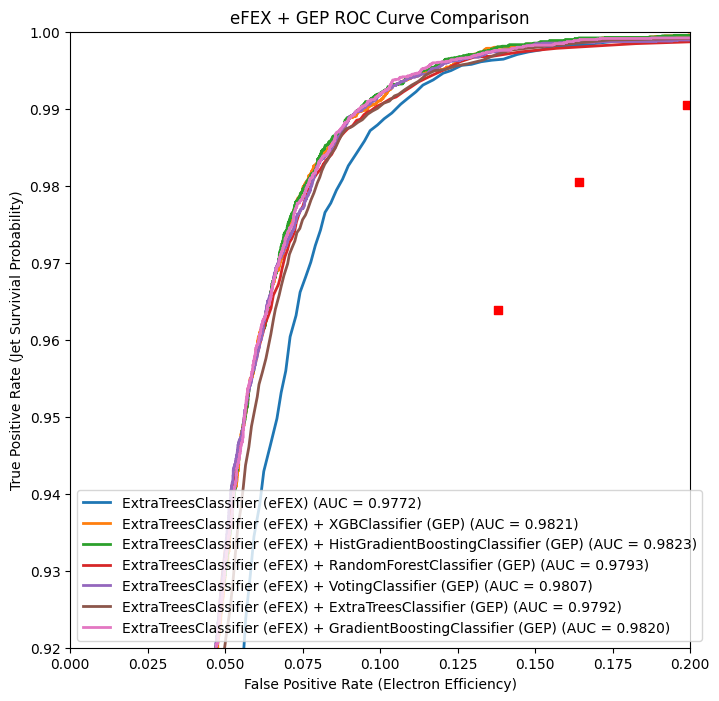

before second training with topo: (eFEX)


Evaluation of HistGradientBoostingClassifier
Confusion Matrix:
 [[19615  1807]
 [  464 14406]]
Accuracy: 0.93742423
Recall: 0.96879623
Precision: 0.88854623
F1 Score: 0.92693755
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     21422
         1.0       0.89      0.97      0.93     14870

    accuracy                           0.94     36292
   macro avg       0.93      0.94      0.94     36292
weighted avg       0.94      0.94      0.94     36292

Mean Squared Error: 0.06257577

after second training with topo: (eFEX + GEP)


Evaluation of XGBClassifier
Confusion Matrix:
 [[19950  1472]
 [  473 14397]]
Accuracy: 0.94640692
Recall: 0.96819099
Precision: 0.90724053
F1 Score: 0.93672533
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95     21422
         1.0       0.91      0.97      0.94     14870


c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


after second training with topo: (eFEX + GEP)


Evaluation of VotingClassifier
Confusion Matrix:
 [[19897  1525]
 [  433 14437]]
Accuracy: 0.94604872
Recall: 0.97088097
Precision: 0.90446059
F1 Score: 0.93649455
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95     21422
         1.0       0.90      0.97      0.94     14870

    accuracy                           0.95     36292
   macro avg       0.94      0.95      0.94     36292
weighted avg       0.95      0.95      0.95     36292

Mean Squared Error: 0.05395128

after second training with topo: (eFEX + GEP)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[19917  1505]
 [  479 14391]]
Accuracy: 0.94533230
Recall: 0.96778749
Precision: 0.90532209
F1 Score: 0.93551323
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95     21422
         1.0       0.91      0.97      0.94     14870

 

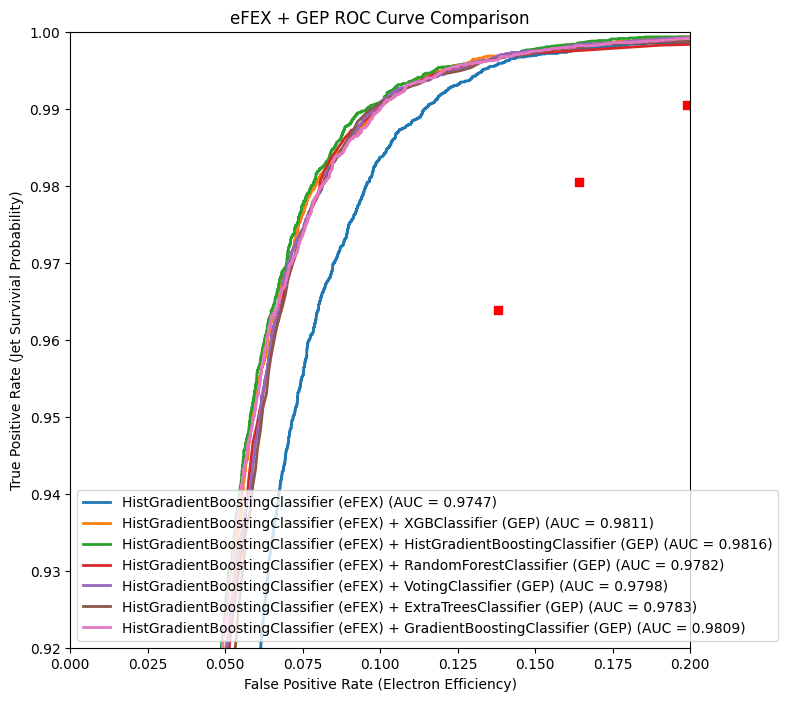

before second training with topo: (eFEX)


Evaluation of RandomForestClassifier
Confusion Matrix:
 [[19793  1629]
 [  541 14329]]
Accuracy: 0.94020721
Recall: 0.96361802
Precision: 0.89791954
F1 Score: 0.92960945
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.92      0.95     21422
         1.0       0.90      0.96      0.93     14870

    accuracy                           0.94     36292
   macro avg       0.94      0.94      0.94     36292
weighted avg       0.94      0.94      0.94     36292

Mean Squared Error: 0.05979279

after second training with topo: (eFEX + GEP)


Evaluation of XGBClassifier
Confusion Matrix:
 [[20040  1382]
 [  515 14355]]
Accuracy: 0.94772953
Recall: 0.96536651
Precision: 0.91218148
F1 Score: 0.93802071
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     21422
         1.0       0.91      0.97      0.94     14870

    acc

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


after second training with topo: (eFEX + GEP)


Evaluation of VotingClassifier
Confusion Matrix:
 [[20045  1377]
 [  553 14317]]
Accuracy: 0.94682024
Recall: 0.96281103
Precision: 0.91225946
F1 Score: 0.93685381
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     21422
         1.0       0.91      0.96      0.94     14870

    accuracy                           0.95     36292
   macro avg       0.94      0.95      0.95     36292
weighted avg       0.95      0.95      0.95     36292

Mean Squared Error: 0.05317976

after second training with topo: (eFEX + GEP)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[20009  1413]
 [  587 14283]]
Accuracy: 0.94489144
Recall: 0.96052455
Precision: 0.90997706
F1 Score: 0.93456782
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     21422
         1.0       0.91      0.96      0.93     14870

 

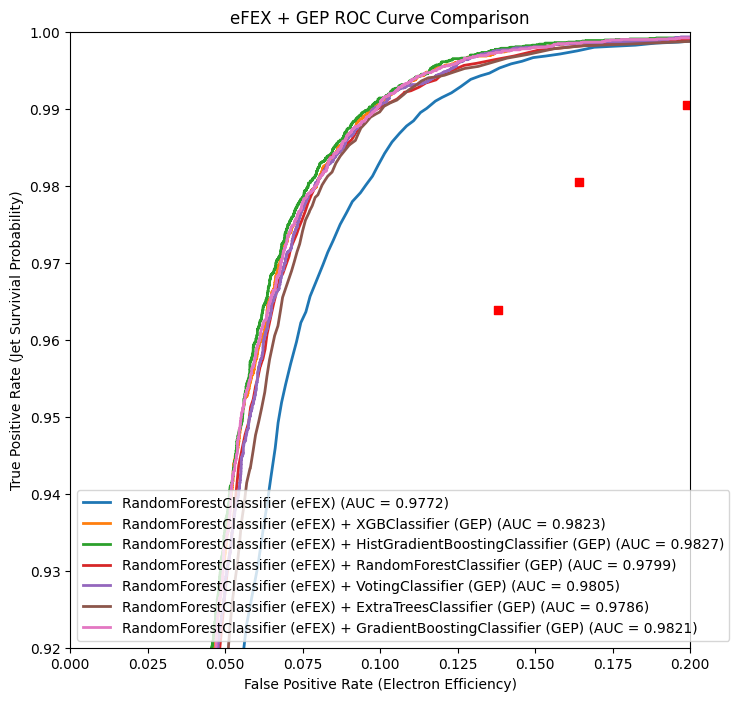

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


before second training with topo: (eFEX)


Evaluation of VotingClassifier
Confusion Matrix:
 [[19332  2090]
 [  513 14357]]
Accuracy: 0.92827620
Recall: 0.96550101
Precision: 0.87292515
F1 Score: 0.91688220
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94     21422
         1.0       0.87      0.97      0.92     14870

    accuracy                           0.93     36292
   macro avg       0.92      0.93      0.93     36292
weighted avg       0.93      0.93      0.93     36292

Mean Squared Error: 0.07172380

after second training with topo: (eFEX + GEP)


Evaluation of XGBClassifier
Confusion Matrix:
 [[19933  1489]
 [  633 14237]]
Accuracy: 0.94152981
Recall: 0.95743107
Precision: 0.90531604
F1 Score: 0.93064453
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     21422
         1.0       0.91      0.96      0.93     14870

    accuracy 

c:\Users\Me\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


after second training with topo: (eFEX + GEP)


Evaluation of VotingClassifier
Confusion Matrix:
 [[19901  1521]
 [  652 14218]]
Accuracy: 0.94012455
Recall: 0.95615333
Precision: 0.90336108
F1 Score: 0.92900781
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     21422
         1.0       0.90      0.96      0.93     14870

    accuracy                           0.94     36292
   macro avg       0.94      0.94      0.94     36292
weighted avg       0.94      0.94      0.94     36292

Mean Squared Error: 0.05987545

after second training with topo: (eFEX + GEP)


Evaluation of ExtraTreesClassifier
Confusion Matrix:
 [[19895  1527]
 [  704 14166]]
Accuracy: 0.93852640
Recall: 0.95265636
Precision: 0.90269547
F1 Score: 0.92700324
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     21422
         1.0       0.90      0.95      0.93     14870

 

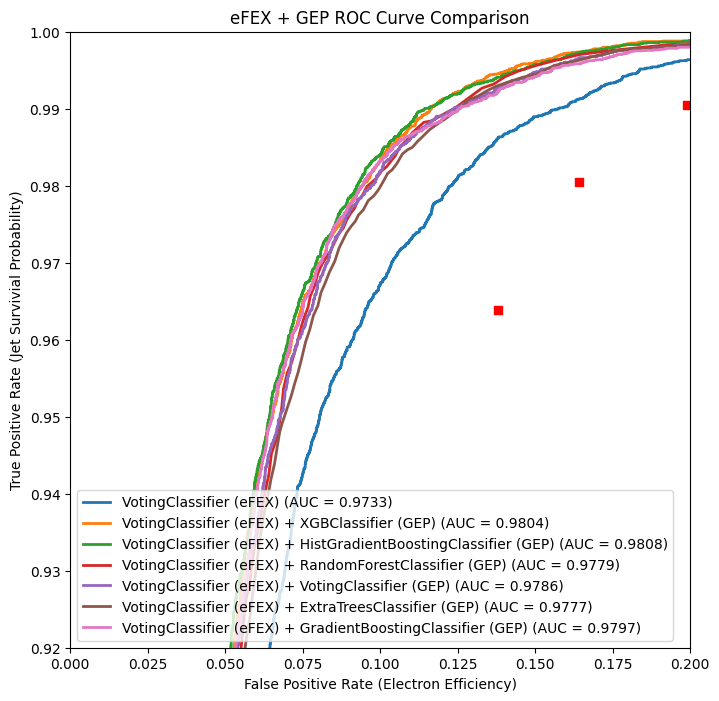

In [29]:
data_subdir = "eFEX_GEP_test"
accept_data_filename = "l1calo_topocluster_test_Zee.root"
reject_data_filename = "ZMUMU_TopoCluster_Supercell_Large.root"
distance_boundaries = [0.0125,0.025,0.05,0.1,0.2,0.4]

classifiers_1 = ["XGBClassifier","MLPClassifier","ExtraTreesClassifier","HistGradientBoostingClassifier","RandomForestClassifier","VotingClassifier"]
classifiers_2 = ["XGBClassifier","HistGradientBoostingClassifier","RandomForestClassifier","VotingClassifier","ExtraTreesClassifier","GradientBoostingClassifier"]

eFEX_GEP_loop(classifiers_1,classifiers_2,accept_data_filename,reject_data_filename,distance_boundaries,data_subdir)

Imported 43 binary classifiers:
['AdaBoostClassifier', 'BaggingClassifier', 'BernoulliNB', 'CalibratedClassifierCV', 'CategoricalNB', 'ClassifierChain', 'ComplementNB', 'DecisionTreeClassifier', 'DummyClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'FixedThresholdClassifier', 'GaussianNB', 'GaussianProcessClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'KNeighborsClassifier', 'LabelPropagation', 'LabelSpreading', 'LinearDiscriminantAnalysis', 'LinearSVC', 'LogisticRegression', 'LogisticRegressionCV', 'MLPClassifier', 'MultiOutputClassifier', 'MultinomialNB', 'NearestCentroid', 'NuSVC', 'OneVsOneClassifier', 'OneVsRestClassifier', 'OutputCodeClassifier', 'PassiveAggressiveClassifier', 'Perceptron', 'QuadraticDiscriminantAnalysis', 'RadiusNeighborsClassifier', 'RandomForestClassifier', 'RidgeClassifier', 'RidgeClassifierCV', 'SGDClassifier', 'SVC', 'TunedThresholdClassifierCV', 'VotingClassifier', 'XGBClassifier']
found preprepared data in ..\data

c:\Users\Me\Desktop\uni temp\Y5\Project\ATLAS2\ATLAS-L1-Trigger-Y4-Project\tertiary_tests\utilities_new_new.py:594: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


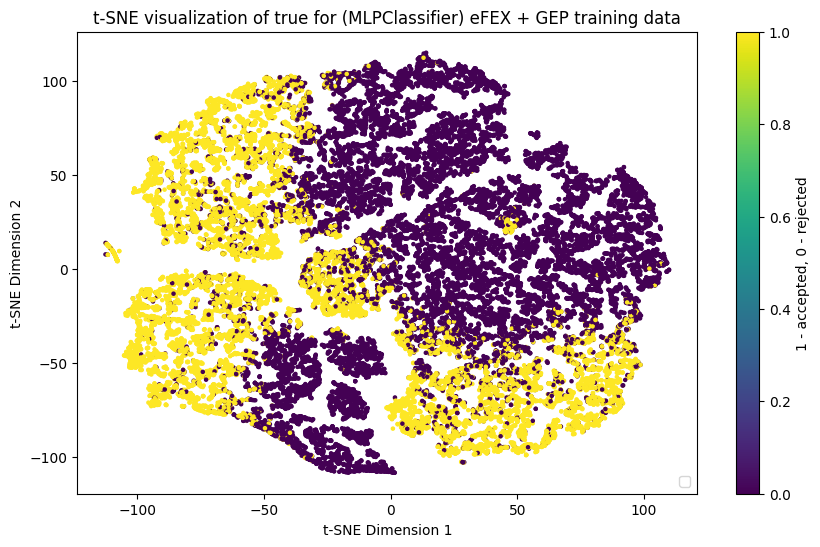

c:\Users\Me\Desktop\uni temp\Y5\Project\ATLAS2\ATLAS-L1-Trigger-Y4-Project\tertiary_tests\utilities_new_new.py:594: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


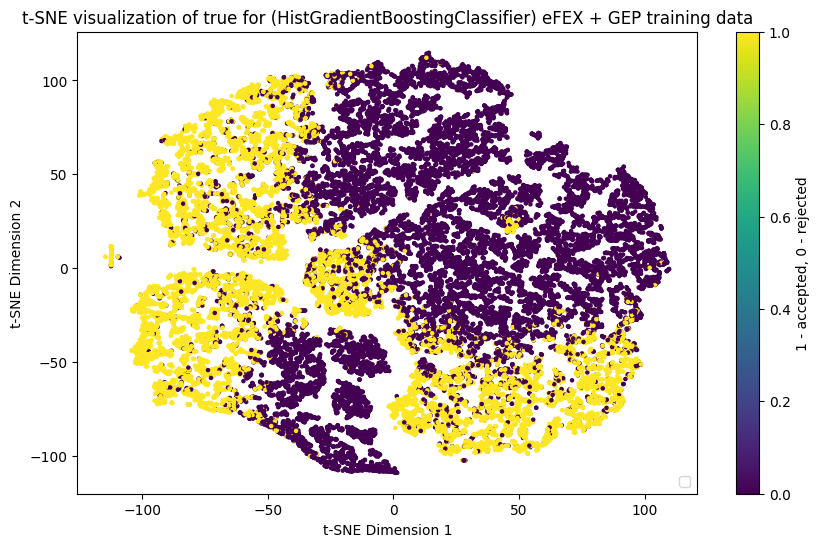

In [26]:
data_subdir = "eFEX_GEP_test"
accept_data_filename = "l1calo_topocluster_test_Zee.root"
reject_data_filename = "ZMUMU_TopoCluster_Supercell_Large.root"
distance_boundaries = [0.0125,0.025,0.05,0.1,0.2,0.4]

classifiers_1 = ["MLPClassifier","HistGradientBoostingClassifier"]
classifiers_2 = ["XGBClassifier","HistGradientBoostingClassifier","RandomForestClassifier","VotingClassifier","ExtraTreesClassifier","GradientBoostingClassifier","SVC"]

eFEX_GEP_loop(classifiers_1,classifiers_2,accept_data_filename,reject_data_filename,distance_boundaries,data_subdir,TSNE_only=True)